In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 25,20

import cartopy.crs as ccrs

from metpy.mapping import c_triangles, c_points, c_polygons
from metpy.mapping.tests.test_MPGridding import station_test_data

from scipy.spatial import Voronoi, Delaunay, ConvexHull

from matplotlib.delaunay.triangulate import Triangulation

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

def plot_triangle(triangle):
    x = [triangle[0,0], triangle[1,0], triangle[2,0], triangle[0,0]]
    y = [triangle[0,1], triangle[1,1], triangle[2,1], triangle[0,1]]
    
    plt.plot(x, y, ":", linewidth=2)

def plot_voronoi_lines(vor):
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k--')

C:\Users\ahaberli\anaconda3\envs\unidata3\lib\site-packages\matplotlib\cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
xp, yp, variable = station_test_data("air_temperature", from_proj, to_proj)

xg, yg = c_points.generate_grid(25000, 25000, c_points.get_boundary_coords(xp, yp))

grid_points = c_points.generate_grid_coords(xg, yg)

In [3]:
points = list(zip(xp, yp))

tri = Delaunay(points)
vor = Voronoi(points, incremental=True)
tri_match = tri.find_simplex(grid_points)


t = Triangulation(xp, yp)

cur_tri = tri_match[7760]
grid = grid_points[7760]

C:\Users\ahaberli\anaconda3\envs\unidata3\lib\site-packages\matplotlib\delaunay\triangulate.py:108: DuplicatePointWarning: Input data contains duplicate x,y points; some values are ignored.
  DuplicatePointWarning,


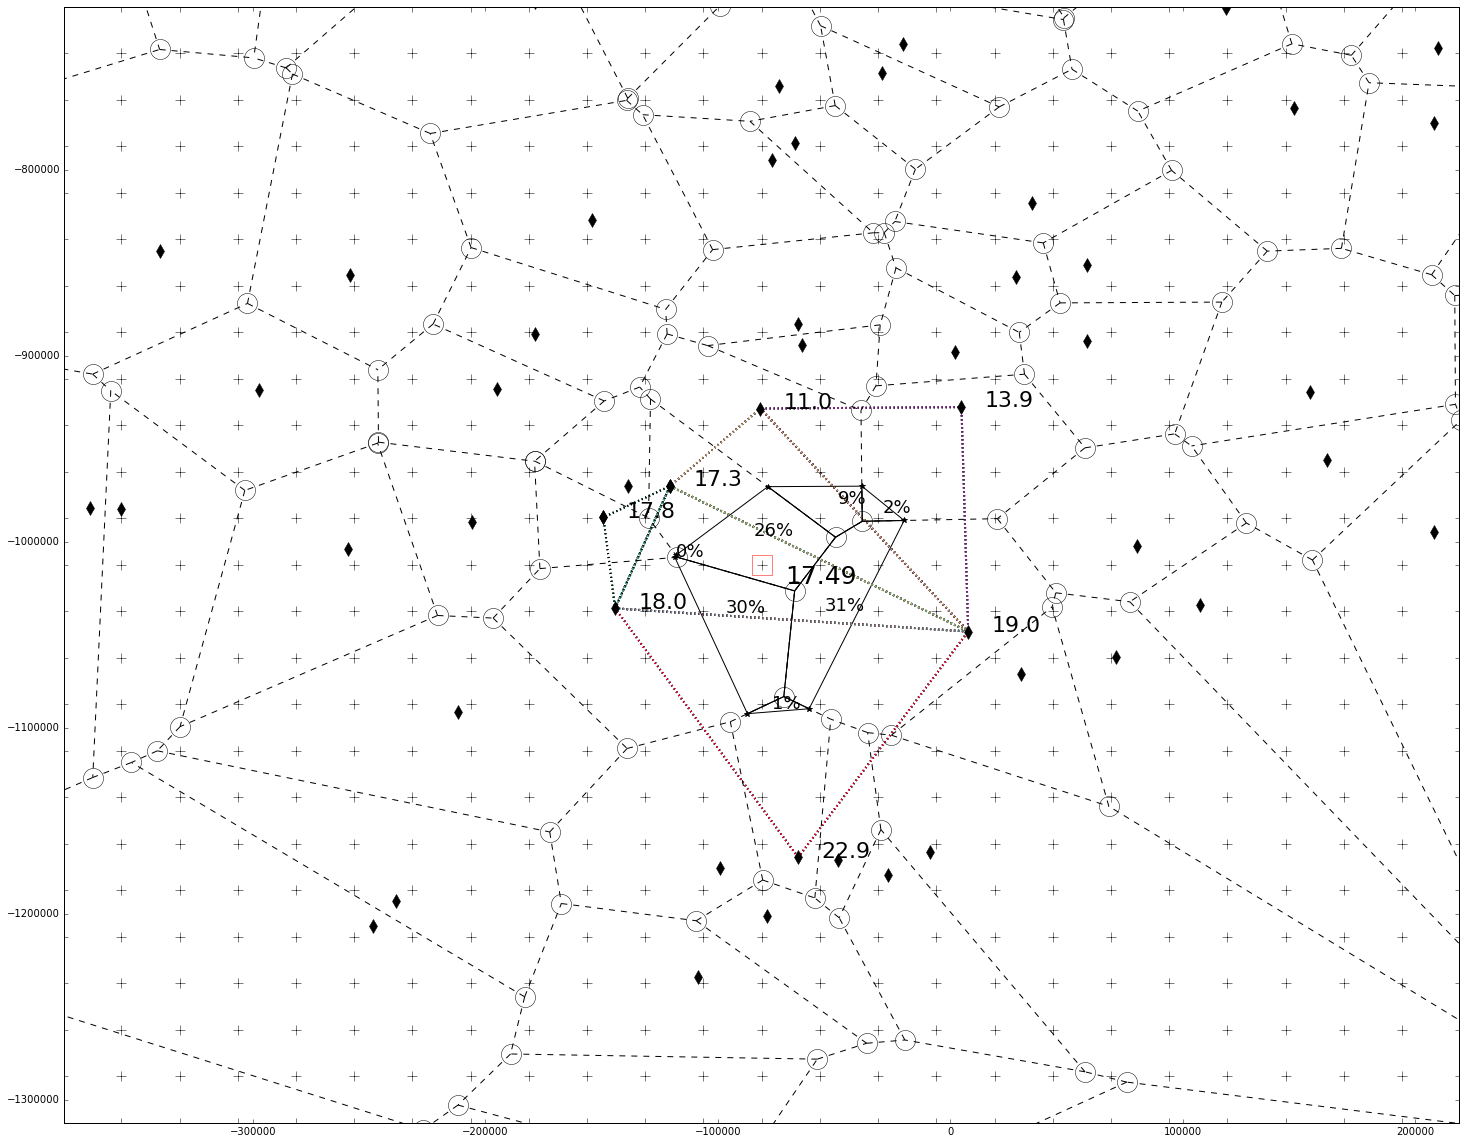

In [4]:
neighbors = c_triangles._find_nn_triangles(tri, cur_tri, grid)

new_tri = tri.simplices[neighbors]

edges = c_triangles._find_local_boundary(tri, neighbors)

starting_indices = [segment[0] for segment in c_polygons._order_edges(edges)]

edge_vertices = tri.points[starting_indices]

polygon_labels = []
area_list = []
num_vertices = len(edge_vertices)

total_area = 0.0

for i in range(num_vertices):

    
    p1 = edge_vertices[i]
    p2 = edge_vertices[(i + 1) % num_vertices]
    p3 = edge_vertices[(i + 2) % num_vertices]

    polygon = []

    c1 = c_triangles._circumcenter(grid[0], grid[1], p1[0], p1[1], p2[0], p2[1])
    c2 = c_triangles._circumcenter(grid[0], grid[1], p2[0], p2[1], p3[0], p3[1])
    polygon.append(c1)
    polygon.append(c2)
    
    plt.plot([c1[0],c2[0]], [c1[1],c2[1]], 'k*')

    for new in new_tri:
        points = tri.points[new]
        plot_triangle(points)
        if p2 in points:
            polygon.append(c_triangles._circumcenter(points[0, 0], points[0, 1],
                                                     points[1, 0], points[1, 1],
                                                     points[2, 0], points[2, 1]))
            
    polygon.append(c1)

    pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
    pts = np.concatenate((pts, [pts[0]]), axis=0)
    
    plt.plot(pts[:,0], pts[:,1], "k-") 
    
    value = variable[(p2[0]==xp) & (p2[1]==yp)]
    
    plt.annotate(str(value[0]), xy=(p2[0]+10000, p2[1]), fontsize=22)    

    cur_area = c_polygons._area(pts)
    total_area += cur_area

    area_list.append(cur_area * value[0])
    
    x_temp = np.mean(pts[:,0])
    y_temp = np.mean(pts[:,1])

    polygon_labels.append((x_temp, y_temp, cur_area))

interp_value = sum([x / total_area for x in area_list])

plt.plot(grid_points[:,0], grid_points[:,1], 'k+', markersize=10)
plt.plot(grid[0], grid[1], "rs", markersize=20, fillstyle='none')

plt.annotate('{0:.2f}'.format(interp_value), xy=(grid[0]+10000, grid[1]-10000), fontsize=25)

polygon_labels = np.array(polygon_labels)

for (x, y, val) in polygon_labels:
    
    plt.annotate("{0:.0f}%".format(100*val/total_area), xy=(x, y), fontsize=18)

plot_voronoi_lines(vor)    
    
plt.plot(xp, yp, "kd", markersize=10)

xlow = grid[0] - 300000
xhigh = grid[0] + 300000
ylow = grid[1] - 300000
yhigh = grid[1] + 300000

plt.xlim(xlow, xhigh)
plt.ylim(ylow, yhigh)

plt.plot(t.circumcenters[:,0], t.circumcenters[:,1], "ko", markersize=20, fillstyle='none')

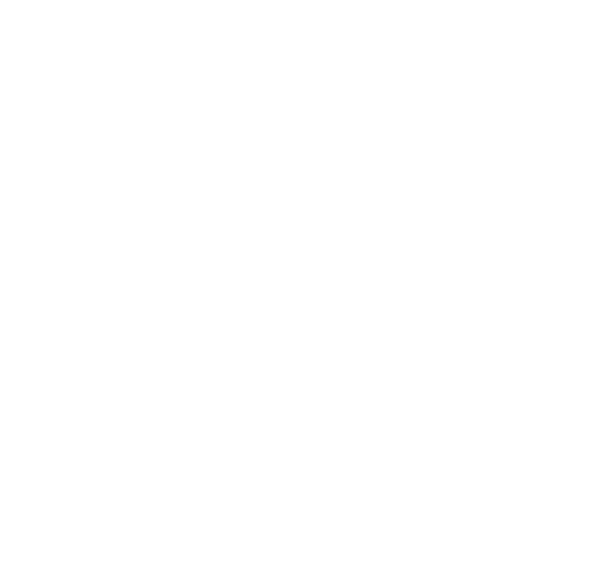

In [5]:
# Create an animation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['animation.html'] = 'html5'
from matplotlib.animation import ArtistAnimation
from scipy.misc import imread
import glob

fig = plt.figure(figsize=(12, 8))


imgs = glob.glob("./nn_frames/*.jpg")

meshes = []

for file in imgs:
    img = imread(file)
    plt.axis('off')
    i = plt.imshow(img[50:-50,75:-75], animated=True)
    fig.tight_layout()
    meshes.append([i])

ArtistAnimation(fig, meshes, interval=500, repeat_delay=5000)